<h1 style="text-align: center;"> Classification of Human Facial Expressions </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Santiago Becerra Cordoba</strong>  
<br>
sab1475@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Sarah Kim</strong>  
<br>
gak604@g.harvard.edu
</div>


<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Jie Zhao</strong>  
<br>
jiz273@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong></strong>  
<br>
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

<div style="text-align: center; width: 80%; margin: 0 auto;">
    <strong>Abstract</strong><br>
    PLACEHOLDER
</div>

## Table of Contents

1. [Introduction](#Introduction)
    - [a. Access](#Access)
    - [b. Load](#Load)
    - [c. Understand](#Understand)

2. [Preprocess](#Preprocess)
    - [a. Missing Data](#Missing-Data)
    - [b. Data Imbalance](#Data-Imbalance)
    - [c. Feature Scaling](#Feature-Scaling)


## Introduction

In this project, we aim to classify human facial expressions using a dataset of images. The data we will use is the FER-2013 dataset, which contains 35,887 grayscale images of size 48x48 pixels. Each image is labeled with one of seven emotions: anger, disgust, fear, happiness, sadness, surprise, and neutral. 

### Access

In [ ]:
import os
import pathlib
import time
import zipfile
import random
import imageio
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import tarfile
import gdown
from PIL import Image
import requests
import scipy.ndimage as ndimage
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GaussianNoise
from tensorflow.keras.layers import Flatten, Input, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import shutil
import platform
import kagglehub

from sklearn.preprocessing import StandardScaler  # Import

In [109]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:05<00:00, 11.1MB/s]

Extracting files...


Path to dataset files: /Users/kayleeyvo/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [112]:
DATA_DIR = os.getcwd() + "/data"

# For mac users
if platform.system() == "Darwin":
    os.system('find . -name ".DS_Store" -delete')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [113]:
for item in os.listdir(path):
    item_path = os.path.join(path, item)

    if os.path.isfile(item_path):
        shutil.copy(item_path, DATA_DIR)
        print(f"Copied file: {item_path}")
    elif os.path.isdir(item_path):
        shutil.copytree(item_path, os.path.join(DATA_DIR, item))
        print(f"Copied directory: {item_path}")

Copied directory: /Users/kayleeyvo/.cache/kagglehub/datasets/msambare/fer2013/versions/1/test
Copied directory: /Users/kayleeyvo/.cache/kagglehub/datasets/msambare/fer2013/versions/1/train


### Load

In [114]:
train_dir = DATA_DIR + "/train"
val_dir = DATA_DIR + "/validation"
val_split = 0.2

if not os.path.exists(val_dir):
    os.makedirs(val_dir, exist_ok=True)
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        val_class_path = os.path.join(val_dir, class_name)
        os.makedirs(val_class_path, exist_ok=True)

        # List all images in the class directory
        images = os.listdir(class_path)
        random.shuffle(images)

        # Move a portion of images to validation
        num_val = int(len(images) * val_split)
        for img in images[:num_val]:
            shutil.move(
                os.path.join(class_path, img), os.path.join(val_class_path, img)
            )

In [115]:
datagen = ImageDataGenerator(rescale=1.0 / 255)

In [116]:
batch_size = 32
target_size = (48, 48)  # generator can resize all images if we want

traingen = datagen.flow_from_directory(
    DATA_DIR + "/train",  # this is the target directory
    target_size=target_size,  # all images will be resized to 150x150
    batch_size=batch_size,
    class_mode="sparse",  # since we use categorical_crossentropy loss, we need binary labels
    color_mode="grayscale",
)
valgen = datagen.flow_from_directory(
    DATA_DIR + "/validation",
    target_size=target_size,
    batch_size=batch_size,
    class_mode="sparse",
    color_mode="grayscale",
)

testgen = datagen.flow_from_directory(
    DATA_DIR + "/test",
    target_size=target_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="sparse",
    color_mode="grayscale",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [117]:
total_images = traingen.samples + valgen.samples + testgen.samples

print("Total images in dataset:", total_images)

Total images in dataset: 35887


### Understand

In [118]:
data_batch, labels_batch = next(traingen)
print("data batch shape:", data_batch.shape)
print("labels batch shape:", labels_batch.shape)

data batch shape: (32, 48, 48, 1)
labels batch shape: (32,)


In [119]:
class_indices = traingen.class_indices
class_labels = {v: k for k, v in class_indices.items()}

In [120]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

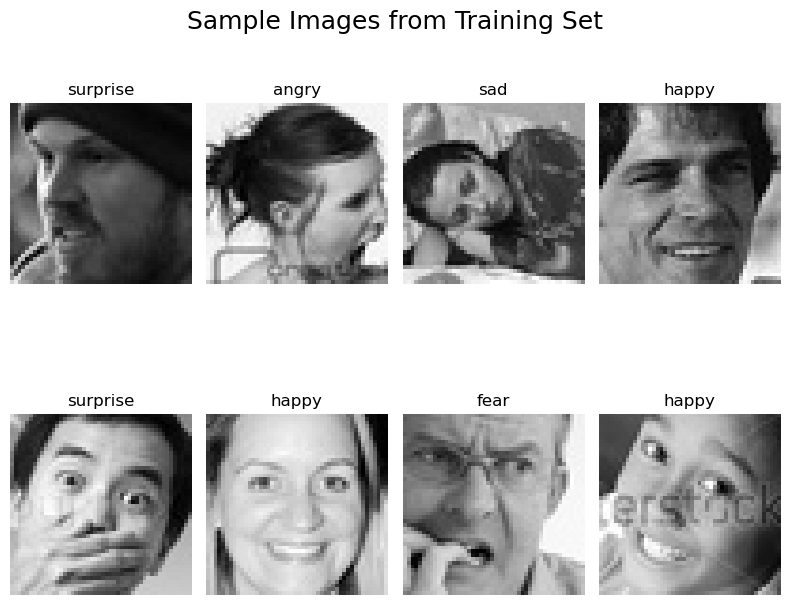

In [121]:
fig, ax = plt.subplots(2, 4, figsize=(8, 8))

axs = ax.ravel()

counter = 0
for batch, labels in traingen:
    for img, label in zip(batch, labels):
        class_index = int(label)
        class_name = class_labels[class_index]

        axs[counter].imshow(img[:, :, 0], cmap="gray")
        axs[counter].set_title(class_name)
        axs[counter].axis("off")

        counter += 1
        if counter >= 8:
            break

    break

plt.suptitle("Sample Images from Training Set", y=0.9, fontsize=18)
plt.tight_layout()

## Preprocess

### Missing Data

### Data Imbalance

### Feature Scaling